In [56]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from itertools import product
os.chdir('/data/arpit.goel/32_RecruitRestarauntPrediction/')


data={}
data['air_reserve']=pd.read_csv('01.RawData/air_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
data['air_store_info']=pd.read_csv('01.RawData/air_store_info.csv')
data['air_visit_data']=pd.read_csv('01.RawData/air_visit_data.csv',parse_dates=['visit_date'])
data['date_info']=pd.read_csv('01.RawData/date_info.csv',parse_dates=['calendar_date'])
data['hpg_reserve']=pd.read_csv('01.RawData/hpg_reserve.csv',parse_dates=['visit_datetime','reserve_datetime'])
data['hpg_store_info']=pd.read_csv('01.RawData/hpg_store_info.csv')
data['store_id_relation']=pd.read_csv('01.RawData/store_id_relation.csv')
data['sample_submission']=pd.read_csv('01.RawData/sample_submission.csv')
data['store_master']=pd.read_csv('02.CleanData/01.StoreRegion.csv')



In [57]:
data['air_visit_data'].loc[:,'log_visitors']=np.log(1+data['air_visit_data'].loc[:,'visitors'])
data['sample_submission'].loc[:,'air_store_id']=data['sample_submission'].loc[:,'id'].map(lambda x: x[:-11])
data['sample_submission'].loc[:,'visit_date']=pd.to_datetime(data['sample_submission'].loc[:,'id'].map(lambda x: x[-10:]))
data['visits_master']=pd.concat([data['air_visit_data'],data['sample_submission']]).groupby(['air_store_id','visit_date'])['log_visitors'].max().unstack()

TEST_PERIOD=42 
TRAINING_WINDOW_SCALE=21 
TRAINING_WINDOW_ROLLING=84 
TRAINING_WINDOW_OVERALL_MEDIAN=63 
TRAINING_WINDOW_OVERALL_MEAN=42 
START_DT=datetime(2017,4,23)
END_DT=min(START_DT+timedelta(days=TEST_PERIOD),data['visits_master'].columns.max())


In [121]:
reservations=pd.concat([data['air_reserve'],pd.merge(data['hpg_reserve'],data['store_id_relation'],how='left',on='hpg_store_id')])
reservations=reservations[reservations['reserve_datetime']<START_DT]
reservations=reservations[reservations['reserve_datetime']>=START_DT-timedelta(days=28)]
reservations=reservations[reservations['visit_datetime']>=START_DT]
reservations=reservations[reservations['visit_datetime']<=END_DT+timedelta(days=1)]
reservations.loc[:,'flag_evening']=(reservations.loc[:,'visit_datetime'].dt.hour>5).astype(np.int64)
reservations.loc[:,'flag_hpg']=(reservations.loc[:,'hpg_store_id'].notnull()).astype(np.int64)
reservations.loc[:,'reserve_1']=reservations.apply(lambda x:x['reserve_visitors']*(1-x['flag_hpg']),axis=1)
reservations.loc[:,'reserve_2']=reservations.apply(lambda x:x['reserve_visitors'],axis=1)
reservations.loc[:,'reserve_3']=reservations.apply(lambda x:x['reserve_visitors']*x['flag_evening'],axis=1)
reservations.loc[:,'reserve_4']=reservations.apply(lambda x:x['reserve_visitors']*x['flag_evening']*(1-x['flag_hpg']),axis=1)
reservations.loc[:,'air_store_id']=reservations.loc[:,'air_store_id'].fillna('hpg')
reservations.loc[:,'reserve_datetime']=reservations.loc[:,'reserve_datetime'].map(lambda x: x.replace(hour=0))
reservations.loc[:,'visit_date']=reservations.loc[:,'visit_datetime'].map(lambda x: x.replace(hour=0))
data['reservations_store']=reservations.groupby(['air_store_id','visit_date'])[['reserve_1','reserve_2','reserve_3','reserve_4']].sum()
data['reservations_all']=reservations.groupby(['visit_date'])[['reserve_1','reserve_2','reserve_3','reserve_4']].sum()


In [104]:
def extrapolate_ts(x):
    if np.isnan(x).sum()>len(x)/2.0 or np.isnan(x).sum()==0:
        return x
    nans=np.isnan(x)
    f=x.nonzero()[0]
    x[nans]=np.interp(nans.nonzero()[0], (~nans).nonzero()[0], x[~nans])
    return x
    
def get_ts_store_features(x,function,window=0):
    if function=='target':
        return x[START_DT:END_DT]
    elif function=='reserve':
        prediction=np.log(1+x)*np.exp(0.0125*np.arange(len(x)))
        return prediction
    train=x[:START_DT-timedelta(days=1)]
    index=pd.date_range(START_DT,START_DT+timedelta(days=TEST_PERIOD-1))
    if function=='overall_mean':
        train=train[-TRAINING_WINDOW_OVERALL_MEAN:]
        prediction=pd.Series(np.tile(np.nanmean(train),len(index)),index=index)
        return prediction
    elif function=='overall_median':
        train=train[-TRAINING_WINDOW_OVERALL_MEDIAN:]
        prediction=pd.Series(np.tile(np.nanmedian(train),len(index)),index=index)
        return prediction
    elif function=='rolling_median':
        train=train[-TRAINING_WINDOW_ROLLING:].values.reshape(int(TRAINING_WINDOW_ROLLING/7),7)
        prediction=pd.Series(np.tile(np.nanmedian(train,axis=0),int(TEST_PERIOD/7)),index=pd.date_range(START_DT,START_DT+timedelta(days=TEST_PERIOD-1)))
        prediction=prediction.fillna(np.nanmedian(train[-TRAINING_WINDOW_OVERALL_MEDIAN:]))
        return prediction
    elif function=='rolling_mean':
        train=train[-TRAINING_WINDOW_ROLLING:].values.reshape(int(TRAINING_WINDOW_ROLLING/7),7)
        prediction=pd.Series(np.tile(np.nanmean(train,axis=0),int(TEST_PERIOD/7)),index=pd.date_range(START_DT,START_DT+timedelta(days=TEST_PERIOD-1)))
        prediction=prediction.fillna(np.nanmean(train[-TRAINING_WINDOW_OVERALL_MEAN:]))
        return prediction
    elif function=='scale':
        train=train[-TRAINING_WINDOW_SCALE:].dropna().sort_values()
        scale=train[-1]-train[1] if len(train)>2 else 0
        scale=pd.Series([scale]*len(index),index=index)
        return scale
    elif function=='last_year':
        train=train[-window:-window+TEST_PERIOD]
        train.index=train.index+timedelta(days=window)
        return extrapolate_ts(train)


In [122]:
master=[x for x in product(data['visits_master'].index,pd.date_range(START_DT,END_DT))]
master=pd.DataFrame(master,columns=['air_store_id','visit_date'])

for feature in ['overall_mean','overall_median','rolling_median','rolling_mean','scale','target']:
    values=data['visits_master'].apply(get_ts_store_features,axis=1,function=feature).unstack().reset_index()
    values.columns=['visit_date','air_store_id',feature]
    master=pd.merge(master,values,on=['air_store_id','visit_date'],how='left')
    
for time in [364,365,366]:
    values=data['visits_master'].apply(get_ts_store_features,axis=1,function='last_year',window=time).unstack().reset_index()
    values.columns=['visit_date','air_store_id','last_year_%d'%time]
    master=pd.merge(master,values,on=['air_store_id','visit_date'],how='left')    
    
for i in range(1,5):
    values=data['reservations_store']['reserve_%d'%i].unstack().apply(get_ts_store_features,axis=1,function='reserve').unstack().reset_index()
    values.columns=['visit_date','air_store_id','reserve_store_%d'%i]
    master=pd.merge(master,values,on=['air_store_id','visit_date'],how='left')    
    values=get_ts_store_features(data['reservations_all']['reserve_%d'%i],function='reserve')
    master['reserve_all_%d'%i]=master['visit_date'].map(values)


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: Mean of empty slice
/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: Mean of empty slice
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice


In [60]:
master=pd.read_csv('02.CleanData/Master_2017-03-12.csv')
master_2=pd.read_csv('02.CleanData/Master_2017-01-29.csv')
test=pd.read_csv('02.CleanData/Master_2017-04-23.csv')
master=master[master['target']>1]
master['intercept']=1
test['intercept']=1
master=master.fillna(master.mean())
test=test.fillna(master.mean())


In [63]:
import statsmodels.api as sm

idv=['last_7','overall_mean','rolling_mean','rolling_median','last_year_364','reserve_store_2','reserve_all_2']

logit1 = sm.OLS(master['target'],master[['intercept']+idv])
result = logit1.fit()
print (result.summary())

master['prediction']=result.predict(master[['intercept']+idv])
test['prediction']=np.round(np.exp(result.predict(test[['intercept']+idv])-1))
test.index=test['air_store_id']+'_'+test['visit_date']
prediction=test['prediction']
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_sample_submission['visitors']=df_sample_submission['id'].map(prediction).fillna(prediction.median())
df_sample_submission.to_csv('03.Submissions/14_Last7Days.csv',index=False)


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     6014.
Date:                Wed, 20 Dec 2017   Prob (F-statistic):               0.00
Time:                        10:31:19   Log-Likelihood:                -21447.
No. Observations:               29421   AIC:                         4.291e+04
Df Residuals:                   29413   BIC:                         4.298e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
intercept          -0.8511      0.049    -

In [52]:
master[idv].describe().T

,count,mean,std,min,25%,50%,75%,max
overall_mean,59261.0,2.809760,0.565427,0.693147,2.409225,2.819173,3.268684,4.681207
rolling_median,59261.0,2.858692,0.649685,0.693147,2.397895,2.890372,3.332205,5.298317
last_year_364,59261.0,2.899089,0.460630,0.693147,2.899089,2.899089,2.899089,5.501258
reserve_store_2,59261.0,2.453145,0.197585,0.693147,2.453145,2.453145,2.453145,7.027971
reserve_all_2,59261.0,10.023628,1.031818,7.561916,9.321955,9.863524,10.731884,12.540187
new_scale_overall_mean,59168.0,4.271309,1.663900,0.000000,3.096545,4.157062,5.176538,11.227352
new_scale_rolling_mean,59168.0,4.291522,1.732694,0.000000,3.055506,4.133643,5.275715,11.601162


In [217]:
master['scale_bin'],bins=pd.qcut(master['scale'],10,retbins=True)
master['scale_bin']=pd.cut(master['scale'],bins=bins)

idv=['overall_mean','rolling_mean','rolling_median','last_year_364','reserve_store_2','reserve_all_2']

coef=[]
model={}
from sklearn.linear_model import LinearRegression
for name,group in master.groupby('scale_bin'):
    reg=LinearRegression()
    reg.fit(group[idv],group['target'])
    coef.append(reg.coef_)
    model[name]=reg
    
    
pd.DataFrame(coef,columns=idv)

,overall_mean,rolling_mean,rolling_median,last_year_364,reserve_store_2,reserve_all_2
0,0.456857,0.374937,0.147747,0.031797,0.078179,0.045699
1,0.236499,0.678870,0.056030,0.084521,0.059748,0.034650
2,0.250269,0.422126,0.281824,0.044071,0.121687,0.052074
3,0.259964,0.323931,0.387992,0.049894,0.099770,0.056820
4,0.273615,0.617703,0.044357,0.114478,0.064558,0.061601
5,0.215214,0.586194,0.158035,0.043048,0.079029,0.082853
6,0.236847,0.631060,0.011183,0.041199,0.171356,0.077326
7,0.219450,0.567967,0.111134,0.083359,0.111044,0.059250
8,0.158616,0.711588,0.020836,0.079585,0.110815,0.078340
9,0.161750,0.662458,0.073090,0.103177,0.137548,0.093759


In [215]:
bins

array([ 0.        ,  0.90885575,  1.1205912 ,  1.28519824,  1.43508453,
        1.56861592,  1.72551008,  1.89711998,  2.12026354,  2.39789527,
        5.6790343 ])

In [231]:
test=pd.read_csv('02.CleanData/Master_2017-04-23.csv')
test['scale_bin']=pd.cut(test['scale'],bins)
test=test.fillna(master_1.mean())

prediction=[]
for name,group in test.groupby(['scale_bin']):
    group['prediction']=np.round(np.exp(model[name].predict(group[idv]))-1)
    prediction.append(group)

predictions=pd.concat(prediction)

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [232]:
predictions.index=predictions['air_store_id']+'_'+predictions['visit_date']
predictions=predictions['prediction']
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_sample_submission['visitors']=df_sample_submission['id'].map(predictions).fillna(predictions.median())
df_sample_submission.to_csv('03.Submissions/12_SegmentedModels.csv',index=False)

In [225]:
predictions.head()

,air_store_id,visit_date,overall_mean,overall_median,rolling_median,rolling_mean,scale,target,last_year_364,last_year_365,...,reserve_store_1,reserve_all_1,reserve_store_2,reserve_all_2,reserve_store_3,reserve_all_3,reserve_store_4,reserve_all_4,scale_bin,prediction
234,air_0382c794b73b51ad,2017-04-23,3.441638,3.465736,3.624252,3.640136,0.71784,2.833285,2.889254,2.887628,...,2.157694,6.630683,2.508813,9.772239,2.478868,9.762154,2.127904,6.601230,"(0, 0.909]",34.0
235,air_0382c794b73b51ad,2017-04-24,3.441638,3.465736,3.367296,3.318493,0.71784,2.833285,2.889254,2.887628,...,2.157694,6.555322,2.508813,9.768325,2.478868,9.767605,2.127904,6.555322,"(0, 0.909]",29.0
236,air_0382c794b73b51ad,2017-04-25,3.441638,3.465736,3.384247,3.435524,0.71784,2.833285,2.889254,2.887628,...,2.157694,6.773898,2.508813,9.929177,2.478868,9.927068,2.127904,6.751486,"(0, 0.909]",31.0
237,air_0382c794b73b51ad,2017-04-26,3.441638,3.465736,3.218876,3.204156,0.71784,2.833285,2.889254,2.887628,...,2.157694,6.946513,2.508813,10.288491,2.478868,10.287769,2.127904,6.942636,"(0, 0.909]",28.0
238,air_0382c794b73b51ad,2017-04-27,3.441638,3.465736,3.295837,3.335242,0.71784,2.833285,2.889254,2.887628,...,2.157694,7.050731,2.508813,10.255075,2.478868,10.254343,2.127904,7.040399,"(0, 0.909]",29.0


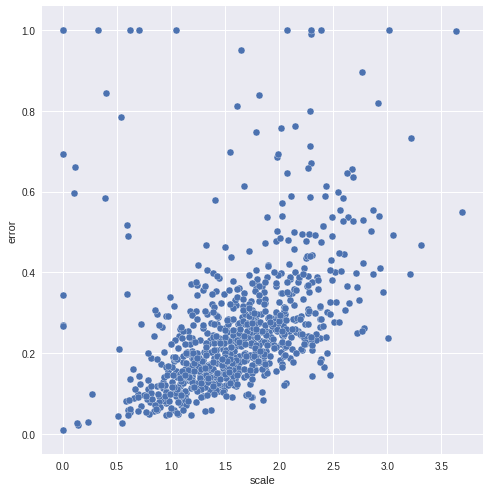

In [203]:
import seaborn as sns
master['error']=np.square(master['prediction']-master['target'])
profile=master.groupby(['air_store_id'])[['error','scale']].mean().reset_index()
profile=pd.merge(profile,data['store_master'][['store_id','prefecture']],left_on='air_store_id',right_on='store_id',how='left')

profile['error']=np.clip(profile['error'],0,1)
profile['error_bin']=pd.qcut(profile['error'],10)
profile['scale_bin']=pd.qcut(profile['scale'],10)
%matplotlib inline

sns.pairplot(x_vars='scale',y_vars='error',data=profile, size=7)


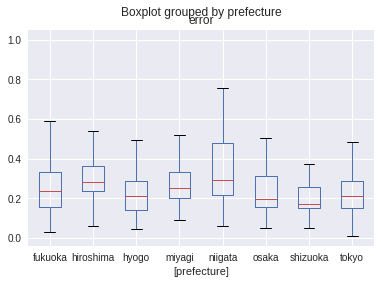

In [206]:
#sns.pairplot(x_vars='scale',y_vars='error',hue='prefecture',data=profile, size=7)
profile[['prefecture','error']].boxplot(by='prefecture')